In [5]:
# Import the necessary libraries
import pandas as pd
import keras_tuner as kt
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import (
    EarlyStopping, 
    ReduceLROnPlateau, 
    ModelCheckpoint, 
    TensorBoard,
    CSVLogger
)
import os
from datetime import datetime
import numpy as np
from sklearn.model_selection import KFold
# Import the necessary libraries



# Define the file paths
subdirectory = "pickle_data_Broetchen"
training_features_path = f"{subdirectory}/training_features.pkl"
validation_features_path = f"{subdirectory}/validation_features.pkl"
test_features_path = f"{subdirectory}/test_features.pkl"
training_labels_path = f"{subdirectory}/training_labels.pkl"
validation_labels_path = f"{subdirectory}/validation_labels.pkl"
test_labels_path = f"{subdirectory}/test_labels.pkl"

# Read the pickle files
training_features = pd.read_pickle(training_features_path)
validation_features = pd.read_pickle(validation_features_path)
test_features = pd.read_pickle(test_features_path)
training_labels = pd.read_pickle(training_labels_path)
validation_labels = pd.read_pickle(validation_labels_path)
#test_labels = pd.read_pickle(test_labels_path)

# Verify the loaded data by printing their shapes and a few rows
print("Loaded Training features dimensions:", training_features.shape)
print("Loaded Validation features dimensions:", validation_features.shape)
print("Loaded Test features dimensions:", test_features.shape)
print()
print("Loaded Training labels dimensions:", training_labels.shape)
print("Loaded Validation labels dimensions:", validation_labels.shape)
#print("Loaded Test labels dimensions:", test_labels.shape)
print()

print("First few rows of loaded training features:")
print(training_features.head())
print()
print("First few rows of loaded training labels:")
print(training_labels.head())


Loaded Training features dimensions: (1462, 24)
Loaded Validation features dimensions: (357, 24)
Loaded Test features dimensions: (355, 24)

Loaded Training labels dimensions: (1462, 1)
Loaded Validation labels dimensions: (357, 1)

First few rows of loaded training features:
      Temp_Cold_current  Temp_Mild_current  Temp_Warm_current  \
1819                  0                  1                  0   
1820                  0                  1                  0   
1821                  0                  0                  1   
1822                  0                  1                  0   
1823                  0                  1                  0   

      Temp_Hot_current  Cloud_ok_current  Cloud_Cloudy_current  \
1819                 0                 0                     1   
1820                 0                 1                     0   
1821                 0                 0                     1   
1822                 0                 0                     1   
18

In [6]:
class BayesianNeuralTuner:
    def __init__(
        self,
        input_shape,
        max_trials=10,
        project_name='nn_tuning',
        log_dir='logs/Broetchen',
        n_folds=3
    ):
        self.input_shape = input_shape
        self.max_trials = max_trials
        self.project_name = project_name
        self.log_dir = os.path.join(log_dir, datetime.now().strftime("%Y%m%d-%H%M%S"))
        self.n_folds = n_folds
        os.makedirs(self.log_dir, exist_ok=True)
        
    def build_model(self, hp):
        # Use factors of 2 for more efficient GPU utilization
        units1_choices = [32, 64, 96, 128]
        units2_choices = [16, 32, 48, 64]
        
        model = Sequential([
            InputLayer(shape=self.input_shape),
            
            # First dropout with tunable rate
            Dropout(hp.Float('dropout1', 0.1, 0.3, step=0.1)),
            
            # First dense layer with conditional units
            Dense(
                units=hp.Choice('units1', units1_choices),
                activation='relu',
                kernel_regularizer=l2(hp.Float(
                    'l2_reg1', 
                    1e-4, 
                    1e-2, 
                    sampling='log'
                )),
                kernel_initializer='he_normal'
            ),
            
            # Second dense layer with conditional units
            Dense(
                units=hp.Choice('units2', units2_choices),
                activation='relu',
                kernel_regularizer=l2(hp.Float(
                    'l2_reg2', 
                    1e-4, 
                    1e-2, 
                    sampling='log'
                )),
                kernel_initializer='he_normal'
            ),
            
            Dense(1)
        ])
        
        # Learning rate with warm restarts
        base_lr = hp.Float(
            'base_learning_rate',
            min_value=1e-4,
            max_value=1e-2,
            sampling='log'
        )
        
        # Optimizer with tunable parameters
        optimizer = AdamW(
            learning_rate=base_lr,
            beta_1=hp.Float('beta_1', 0.9, 0.999),
            beta_2=hp.Float('beta_2', 0.9, 0.999),
            weight_decay=hp.Float('weight_decay', 1e-4, 1e-2, sampling='log')
        )
        
        model.compile(
            optimizer=optimizer,
            loss='mse',
            metrics=['mape']
        )
        
        return model
    
    def get_callbacks(self, checkpoint_path, fold=None):
        fold_suffix = f'_fold_{fold}' if fold is not None else ''
        return [
            EarlyStopping(
                monitor='val_mape',
                patience=5,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_mape',
                factor=0.5,
                patience=3,
                min_lr=1e-6,
                verbose=1
            ),
            ModelCheckpoint(
                filepath=checkpoint_path.format(fold=fold_suffix),
                monitor='val_mape',
                save_best_only=True,
                verbose=1
            ),
            TensorBoard(
                log_dir=os.path.join(self.log_dir, f'fold{fold_suffix}'),
                histogram_freq=1,
                write_graph=True
            ),
            CSVLogger(
                os.path.join(self.log_dir, f'training_log{fold_suffix}.csv'),
                separator=',',
                append=False
            )
        ]
    
    def cross_validate_hyperparameters(self, hp, x, y, batch_size):
        """Perform k-fold cross-validation for a set of hyperparameters"""
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        scores = []
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(x)):
            x_train_fold = x[train_idx]
            y_train_fold = y[train_idx]
            x_val_fold = x[val_idx]
            y_val_fold = y[val_idx]
            
            model = self.build_model(hp)
            checkpoint_path = os.path.join(self.log_dir, 'model_cv_{fold}.h5')
            callbacks = self.get_callbacks(checkpoint_path, fold)
            
            model.fit(
                x_train_fold,
                y_train_fold,
                epochs=100,
                batch_size=batch_size,
                validation_data=(x_val_fold, y_val_fold),
                callbacks=callbacks,
                verbose=0
            )
            
            scores.append(model.evaluate(x_val_fold, y_val_fold)[0])
        
        return np.mean(scores)
    
    def search(self, training_features, training_labels, validation_data, batch_size=24):
        checkpoint_path = os.path.join(self.log_dir, 'best_model.keras')
        
        # Initialize Bayesian Optimization tuner
        tuner = kt.BayesianOptimization(
            self.build_model,
            objective=kt.Objective('val_mape', direction='min'),
            max_trials=self.max_trials,
            directory=self.log_dir,
            project_name=self.project_name,
            overwrite=False
        )
        
        # Print search space summary
        tuner.search_space_summary()
        
        # Implement early stopping for the hyperparameter search
        stop_early = EarlyStopping(
            monitor='val_loss',
            min_delta=1e-4,
            patience=3
        )
        
        # Search with cross-validation
        tuner.search(
            training_features,
            training_labels,
            epochs=100,
            batch_size=batch_size,
            validation_data=validation_data,
            callbacks=self.get_callbacks(checkpoint_path),
            verbose=1
        )
        
        # Get best hyperparameters
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        
        # Print detailed results
        print("\nBest Hyperparameters:")
        for param, value in best_hps.values.items():
            print(f"{param}: {value}")
        
        # Build and train final model with best parameters
        best_model = tuner.hypermodel.build(best_hps)
        
        history = best_model.fit(
            training_features,
            training_labels,
            epochs=100,
            batch_size=batch_size,
            validation_data=validation_data,
            callbacks=self.get_callbacks(checkpoint_path),
            verbose=1
        )
        
        return best_model, history, best_hps


In [7]:

tuner = BayesianNeuralTuner(
    input_shape=(training_features.shape[1],),
    max_trials=30,
    n_folds=3
)

best_model, history, best_hps = tuner.search(
    training_features,
    training_labels,
    validation_data=(validation_features, validation_labels)
)

Trial 30 Complete [00h 00m 09s]
val_mape: 11.657032012939453

Best val_mape So Far: 10.51879596710205
Total elapsed time: 00h 06m 19s

Best Hyperparameters:
dropout1: 0.2
units1: 128
l2_reg1: 0.0011086472951286996
units2: 48
l2_reg2: 0.0038728810982865875
base_learning_rate: 0.009903851978843156
beta_1: 0.930935550414038
beta_2: 0.965955036429823
weight_decay: 0.0020920762424050656


Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 130125.7969 - mape: 75.0301
Epoch 1: val_mape improved from inf to 20.91248, saving model to logs/Broetchen/20250108-142213/best_model.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 129169.9531 - mape: 74.6458 - val_loss: 6578.6724 - val_mape: 20.9125 - learning_rate: 0.0099
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14715.9873 - mape: 22.0606
Epoch 2: val_mape improved from 20.91248 to 16.91853, saving model to logs/Broetchen/20250108-142213/best_model.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 14688.7305 - mape: 22.0423 - val_loss: 4465.2480 - val_mape: 16.9185 - learning_rate: 0.0099
Epoch 3/100
57/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9693.1494 - mape: 18.2127
Epoch 3: val_mape improved from 16.91853 to 11.74587, saving model to logs/Broetchen/20250108-142213/best_model.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9719.3232 - mape: 18.2054 - val_loss: 3148.4614 - val_mape: 11.

In [8]:
early_stopping = EarlyStopping(
    monitor='val_mape',  # Überwachung der Validierungsverlust
    patience=10,         # Anzahl der Epochen ohne Verbesserung
    restore_best_weights=True  # Stellt das Modell mit den besten Gewichten wieder her
)
# Train the final model
history = best_model.fit(
    training_features,
    training_labels,
    epochs=100,
    batch_size=24,
    validation_data=(validation_features, validation_labels),
    callbacks=[early_stopping]
)

Epoch 1/100


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6582.6162 - mape: 14.9125 - val_loss: 3093.7393 - val_mape: 12.5027
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6854.1118 - mape: 16.0447 - val_loss: 3303.7646 - val_mape: 11.5112
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6386.9453 - mape: 14.7490 - val_loss: 3400.7632 - val_mape: 11.1527
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6681.0698 - mape: 14.7354 - val_loss: 3136.0049 - val_mape: 11.3534
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6687.2031 - mape: 15.1368 - val_loss: 2845.5764 - val_mape: 11.4761
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6670.3691 - mape: 15.3895 - val_loss: 2876.2776 - val_mape: 10.7869
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6140.3545 - mape: 14.8220 - val_loss: 3234.1235 - val_mape: 11.0695
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6629.0078 - mape: 14.7826 - val_loss: 2968.7048 - val_mape: 11.1

In [9]:
# Saving the trained Model
best_model.save("python_model_Broetchen.h5")

In [10]:
# Making Predictions and Evaluating the Model
import numpy as np

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

training_predictions = best_model.predict(training_features)
validation_predictions = best_model.predict(validation_features)
print(f"MAPE on the Training Data: {mape(training_labels, training_predictions):.2f}%")
print(f"MAPE on the Validation Data: {mape(validation_labels, validation_predictions):.2f}%")

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
MAPE on the Training Data: 12.15%
MAPE on the Validation Data: 10.50%


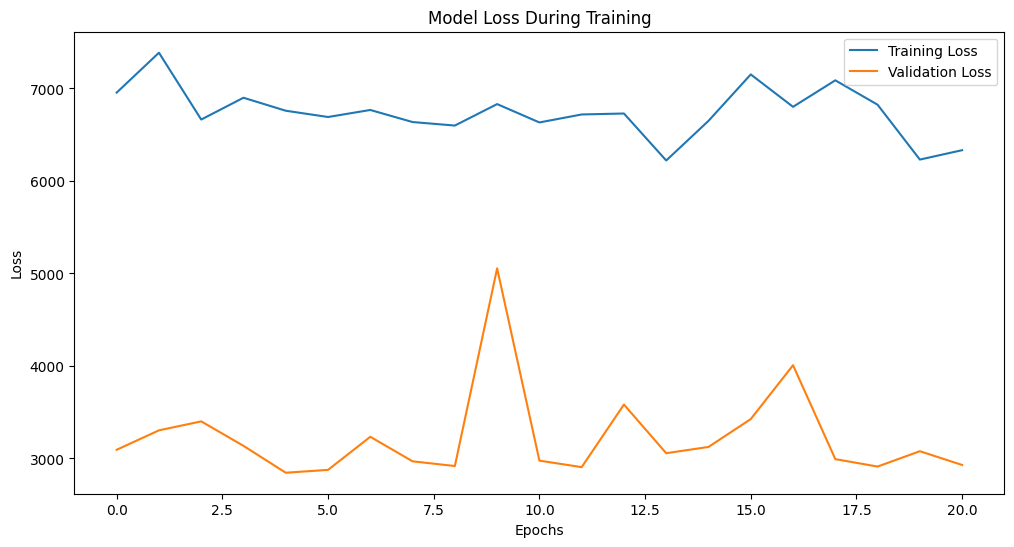

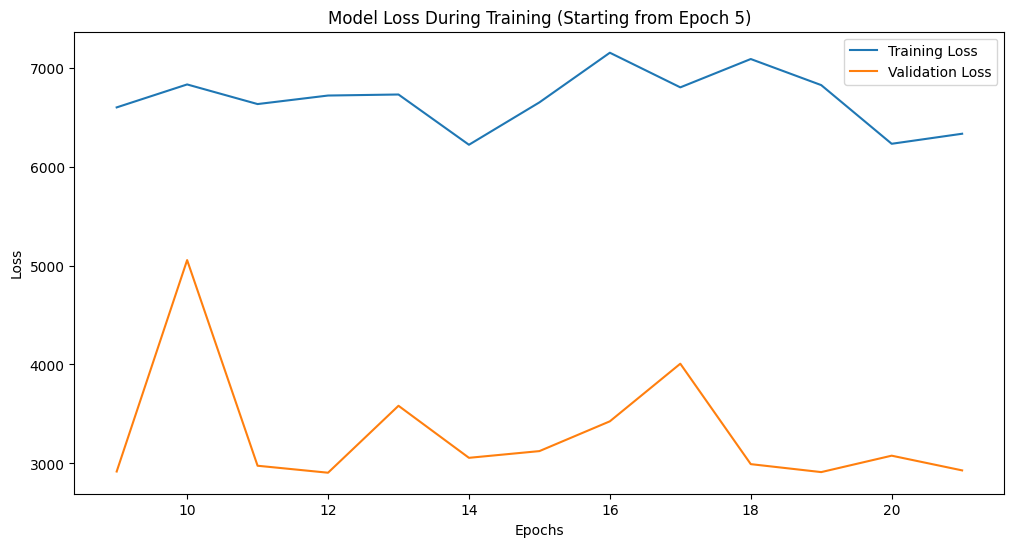

In [11]:
# Plotting Training History
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Training History (ab der 5. Epoche)
import matplotlib.pyplot as plt

# Schneide die Verlaufsdaten ab der 5. Epoche
epochs_to_plot = range(9, len(history.history['loss']) + 1)
training_loss = history.history['loss'][8:]
validation_loss = history.history['val_loss'][8:]

plt.figure(figsize=(12, 6))
plt.plot(epochs_to_plot, training_loss, label='Training Loss')
plt.plot(epochs_to_plot, validation_loss, label='Validation Loss')
plt.title('Model Loss During Training (Starting from Epoch 5)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


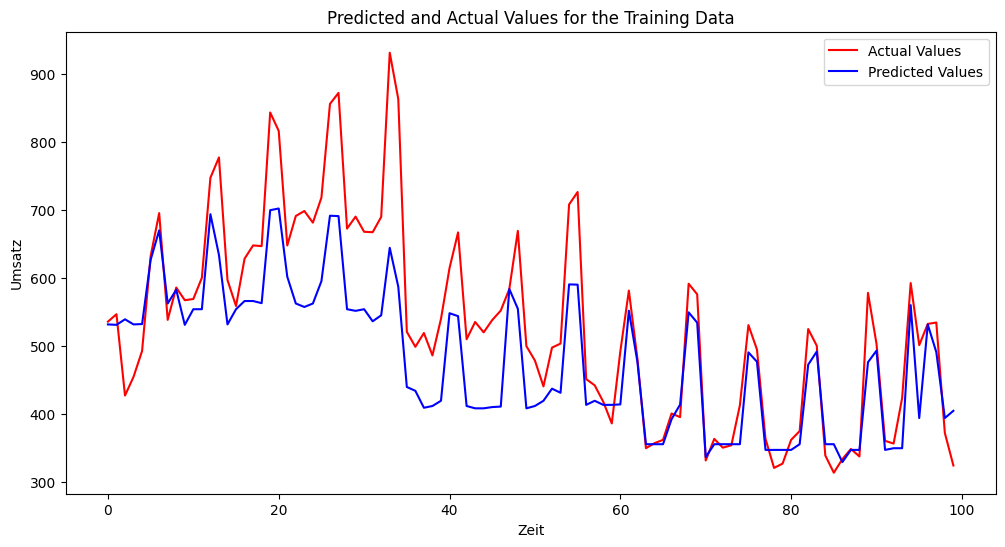

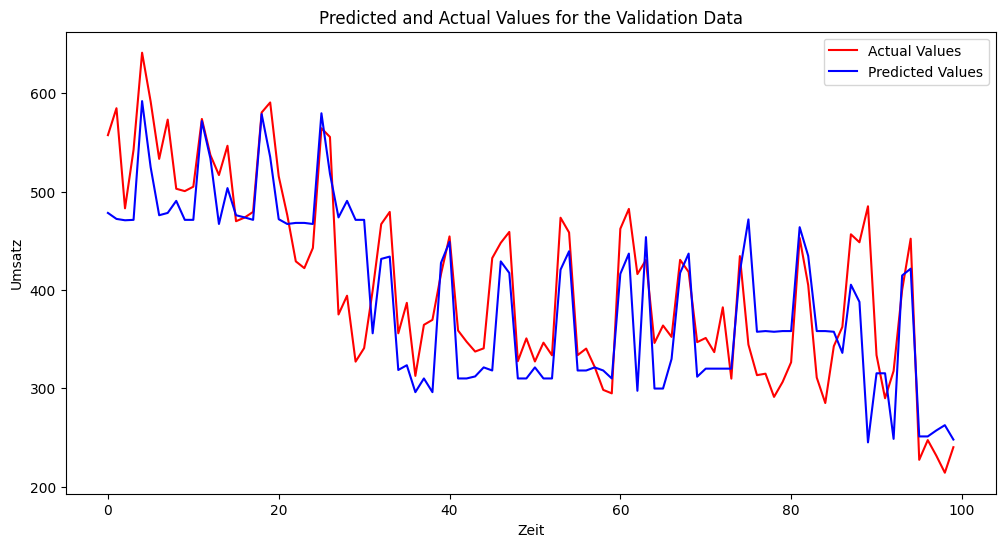

In [12]:
def plot_predictions(data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data['actual'], label='Actual Values', color='red')
    plt.plot(data['prediction'], label='Predicted Values', color='blue')
    plt.title(title)
    plt.xlabel('Zeit')
    plt.ylabel('Umsatz')
    plt.legend()
    plt.show()

# Ensure that training_predictions, validation_predictions, training_labels, and validation_labels are numpy arrays
training_predictions = np.array(training_predictions).flatten()
validation_predictions = np.array(validation_predictions).flatten()
training_labels = np.array(training_labels).flatten()
validation_labels = np.array(validation_labels).flatten()

# print the type of the predictions
print(type(training_predictions))
print(type(validation_predictions))

# Create DataFrames with 1-dimensional arrays
data_train = pd.DataFrame({'prediction': training_predictions, 'actual': training_labels})
data_validation = pd.DataFrame({'prediction': validation_predictions, 'actual': validation_labels})

# Plot predictions
plot_predictions(data_train.head(100), 'Predicted and Actual Values for the Training Data')
plot_predictions(data_validation.head(100), 'Predicted and Actual Values for the Validation Data')

***VORHERSAGE TESTZEITRAUM***

In [13]:
test_predictions = best_model.predict(test_features)
#print("Predictions for test data:", test_predictions[:5])  # Display first 5 predictions
# Größe des Arrays anzeigen
print("Größe des Arrays (shape):", test_predictions.shape)
test_predictions = pd.DataFrame(test_predictions)
test_predictions

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Größe des Arrays (shape): (355, 1)


,0
0,465.057068
1,488.873901
2,488.873901
3,600.035461
4,529.572266
...,...
350,499.357483
351,594.047668
352,573.999207
353,499.701416


In [14]:
data_test = pd.read_csv("../../../0_DataPreparation/00_data/data_with_lag/Testdaten_with_lag.csv")
data_test = data_test[data_test["Warengruppe_2"] == 1]
data_test

,id,Datum,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,Temp_Very_Cold_current,Temp_Very_Cold_prev,...,zwischen_den_jahren_next,Number_of_ships_scaled_current,Number_of_ships_scaled_prev,Number_of_ships_scaled_next,Cloud_ok_current,Cloud_ok_prev,Cloud_ok_next,Wind_ok_current,Wind_ok_prev,Wind_ok_next
355,1808012,2018-08-01,0,1,0,0,0,0,0,0.0,...,0.0,0.0,0.2,0.0,1,0.0,1.0,1,1.0,1.0
356,1808022,2018-08-02,0,1,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,1,1.0,1.0,1,1.0,1.0
357,1808032,2018-08-03,0,1,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.2,1,1.0,1.0,1,1.0,1.0
358,1808042,2018-08-04,0,1,0,0,0,0,0,0.0,...,0.0,0.2,0.0,0.0,1,1.0,0.0,1,1.0,1.0
359,1808052,2018-08-05,0,1,0,0,0,0,0,0.0,...,0.0,0.0,0.2,0.0,0,1.0,1.0,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,1907262,2019-07-26,0,1,0,0,0,0,0,0.0,...,0.0,0.0,0.2,0.6,1,0.0,1.0,1,1.0,0.0
706,1907272,2019-07-27,0,1,0,0,0,0,0,0.0,...,0.0,0.6,0.0,0.4,1,1.0,1.0,0,1.0,1.0
707,1907282,2019-07-28,0,1,0,0,0,0,0,0.0,...,0.0,0.4,0.6,0.2,1,1.0,0.0,1,0.0,1.0
708,1907292,2019-07-29,0,1,0,0,0,0,0,0.0,...,0.0,0.2,0.4,0.2,0,1.0,0.0,1,1.0,1.0


In [15]:
# Erstelle Ziel csv Datei

predictions_df = pd.DataFrame({
    'id': data_test['id'].values,
    'Umsatz': test_predictions[0].values
}).reset_index(drop=True)

# Save to a CSV file
#output_csv_path = "/workspaces/bakery_sales_prediction/3_Model/02_Franz/V3_lag/Umsatzvorhersage_Broetchen_Hochladeformat.csv"

predictions_df.to_csv('Broetchen_Umsatzvorhersage.csv', index=False)
print(f"CSV Datei erstellt")

CSV Datei erstellt
